In [1]:
pip install mtcnn tensorflow opencv-python numpy


   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.9 MB 2.4 MB/s eta 0:00:01
   ---------------------- ----------------- 1.0/1.9 MB 2.4 MB/s eta 0:00:01
   -------------------------------------- - 1.8/1.9 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.3.2
    Uninstalling joblib-1.3.2:
      Successfully uninstalled joblib-1.3.2
Note: you may need to restart the kernel to use updated packages.


In [17]:
import zipfile

# Path to the lfw.zip file
zip_file_path = 'archive.zip'

# Extract the contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('lfw')  # Extract to 'lfw' directory

KeyboardInterrupt: 

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
def load_image_pairs(csv_file, base_path):
    """
    Load matched image pairs from CSV.
    The CSV format is:
    name, imagenum1, imagenum2
    """
    pairs = pd.read_csv(csv_file)
    image_pairs = []
    labels = []
    
    for index, row in pairs.iterrows():
        person_name = row['name']
        img1_path = f"{base_path}/{person_name}/{person_name}_{str(row['imagenum1']).zfill(4)}.jpg"
        img2_path = f"{base_path}/{person_name}/{person_name}_{str(row['imagenum2']).zfill(4)}.jpg"
        
        # Load and preprocess the images
        img1 = tf.keras.preprocessing.image.load_img(img1_path, target_size=(250, 250))
        img2 = tf.keras.preprocessing.image.load_img(img2_path, target_size=(250, 250))
        img1 = tf.keras.preprocessing.image.img_to_array(img1)
        img2 = tf.keras.preprocessing.image.img_to_array(img2)
        
        image_pairs.append((img1, img2))
        labels.append(1)  # Label as matched pair (since both images are from the same person)
        
    return np.array(image_pairs), np.array(labels)


In [19]:
# Define a simple CNN for feature extraction
def build_cnn_model(input_shape=(250, 250, 3), dropout_rate=0.5):
    """Build CNN model with Monte Carlo Dropout."""
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))  # Dropout for Monte Carlo Dropout
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [20]:
# Compile and train the model
def train_model(model, train_data, train_labels, val_data, val_labels, epochs=10, batch_size=32):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, 
                        validation_data=(val_data, val_labels))
    return history

In [21]:
# Monte Carlo Dropout during testing
def monte_carlo_dropout_predict(model, test_data, num_samples=30):
    predictions = []
    for _ in range(num_samples):
        preds = model.predict(test_data, verbose=0)
        predictions.append(preds)
    predictions = np.array(predictions)
    # Mean and uncertainty
    mean_predictions = np.mean(predictions, axis=0)
    uncertainty = np.var(predictions, axis=0)
    return mean_predictions, uncertainty

In [22]:
# Load the matched and mismatched pairs for training and testing
base_path = 'lfw/lfw-deepfunneled/lfw-deepfunneled'  # Folder containing the image subdirectories
train_pairs, train_labels = load_image_pairs('lfw/matchpairsDevTrain.csv', base_path)
test_pairs, test_labels = load_image_pairs('lfw/matchpairsDevTest.csv', base_path)

In [23]:
# Train and test data split
train_img1, train_img2 = zip(*train_pairs)
train_img1 = np.array(train_img1)
train_img2 = np.array(train_img2)

In [24]:
# Simple Siamese CNN approach: Feed both images through same model
input_shape = (250, 250, 3)
cnn_model = build_cnn_model(input_shape)

In [25]:
# Compile and train the CNN
train_images = np.concatenate([train_img1, train_img2], axis=0)
train_targets = np.concatenate([train_labels, train_labels], axis=0)
history = train_model(cnn_model, train_images, train_targets, train_images, train_targets)

Epoch 1/10
69/69 [==============================] - 127s 2s/step - loss: 0.0159 - accuracy: 0.9982 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
69/69 [==============================] - 101s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
69/69 [==============================] - 101s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
69/69 [==============================] - 128s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
69/69 [==============================] - 87s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
69/69 [==============================] - 93s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
69/69 [==============================] - 92s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss

In [26]:
# Testing with Monte Carlo Dropout
test_img1, test_img2 = zip(*test_pairs)
test_img1 = np.array(test_img1)
test_img2 = np.array(test_img2)
mean_predictions, uncertainty = monte_carlo_dropout_predict(cnn_model, test_img1)

In [27]:
# Evaluate accuracy and model uncertainty
threshold = 0.5  # Binary classification threshold
predicted_labels = (mean_predictions >= threshold).astype(int)
accuracy = accuracy_score(test_labels, predicted_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Uncertainty in predictions: {np.mean(uncertainty)}")


Test Accuracy: 100.00%
Uncertainty in predictions: 0.0


In [34]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Matched', 'Mismatched'], yticklabels=['Matched', 'Mismatched'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


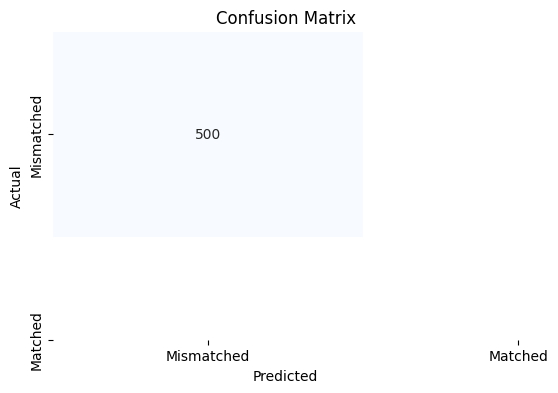

In [35]:
plot_confusion_matrix(test_labels, predicted_labels)
